In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt

from training.util import sgd, plot_losses, adam, lr_scheduler, wilson_scheduler

/home/flo/anaconda3/envs/bdl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
import experiments.base.cifar as cifar

batch_size = 128
trainloader = cifar.cifar10_trainloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size=batch_size, subsample=5000)
testloader = cifar.cifar10_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size=batch_size)
#stl_testloader = cifar.stl10_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size=128)

In [7]:
import experiments.base.cifar as cifar
corrupted_testloader = cifar.cifar10_corrupted_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", intensity=4, batch_size=128)

: 

: 

In [9]:
from training.pp import MAP
from training.swag import SwagModel

layers = [
    ("preresnet-20", (32, 3, 10)),
    ("logsoftmax", ())
]

config = {
    "deviation_samples": 30,
    "mean_samples": 100,
    "start_epoch": 161
}

model = SwagModel(layers, config)

model.train_model(300, torch.nn.NLLLoss(), sgd(1e-1, weight_decay=3e-4, momentum=0.9, nesterov=True), trainloader, batch_size, device, scheduler_factory=wilson_scheduler(161, 0.1, 0.01))
#model.load_state_dict(torch.load("/mnt/d/Uni/Bachelorarbeit/results/CIFAR10/2/results/MAP/log/rep_00model.tar"))
model.to(device)

Epoch 0: loss 2.042579174041748
SWAG: Collected 0 out of 30 deviation samples and 0 out of 100 parameter samples
Epoch 1: loss 1.7964861392974854
SWAG: Collected 0 out of 30 deviation samples and 0 out of 100 parameter samples
Epoch 2: loss 1.6696503162384033
SWAG: Collected 0 out of 30 deviation samples and 0 out of 100 parameter samples
Epoch 3: loss 1.594142198562622
SWAG: Collected 0 out of 30 deviation samples and 0 out of 100 parameter samples
Epoch 4: loss 1.5125367641448975
SWAG: Collected 0 out of 30 deviation samples and 0 out of 100 parameter samples
Epoch 5: loss 1.4249951839447021
SWAG: Collected 0 out of 30 deviation samples and 0 out of 100 parameter samples
Epoch 6: loss 1.3835885524749756
SWAG: Collected 0 out of 30 deviation samples and 0 out of 100 parameter samples
Epoch 7: loss 1.315809965133667
SWAG: Collected 0 out of 30 deviation samples and 0 out of 100 parameter samples
Epoch 8: loss 1.317182183265686
SWAG: Collected 0 out of 30 deviation samples and 0 out of 

SwagModel(
  (model): Sequential(
    (0): PreResNet(
      (model): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PreBasicBlock(
          (main_path): Sequential(
            (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (1): ReLU()
            (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (4): ReLU()
            (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (skip_path): Identity()
        )
        (2): PreBasicBlock(
          (main_path): Sequential(
            (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (1): ReLU()
            (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [10]:
import experiments.base.multiclass_classification as exp

exp.eval_model(model, 5, testloader, device)

 Accuracy: 0.7347999811172485
 Avg Log Likelihood: -1.2561177015304565
 Avg Likelihood: 0.6561229228973389
 ECE: 0.07758343744277954


(tensor(0.7348),
 tensor(-1.2561),
 tensor(0.6561),
 <training.calibration.ClassificationCalibrationResults at 0x7fdf1ca64490>)

In [ ]:
from training.bbb import BBBModel, GaussianPrior

prior = GaussianPrior(torch.tensor(0), torch.tensor(1))
layers = [
    ("variational-preresnet-20", (32, 3, 10, prior)),
    ("logsoftmax", ())
]

model = BBBModel(layers)

model.train_model(120, torch.nn.NLLLoss(), sgd(1e-1), trainloader, batch_size, device, scheduler_factory=lr_scheduler([80, 120], 0.1), mc_samples=2, kl_rescaling=0.5)

In [ ]:
import experiments.base.multiclass_classification as exp

model.to(device)
exp.eval_model(model, 5, corrupted_testloader, device)

tensor(0.5264)
 Accuracy: 0.37957367300987244
 Avg Log Likelihood: -2.0528364181518555
 Avg Likelihood: 0.30053094029426575
 ECE: 0.146800649462405


(tensor(0.3796),
 tensor(-2.0528),
 tensor(0.3005),
 <training.calibration.ClassificationCalibrationResults at 0x7fcc00161f70>)

In [19]:
import experiments.base.multiclass_classification as exp

exp.eval_model(model, 5, testloader, device)

 Accuracy: 0.720300018787384
 Avg Log Likelihood: -1.1909916400909424
 Avg Likelihood: 0.6958616971969604
 ECE: 0.15854743110537528


(tensor(0.7203),
 tensor(-1.1910),
 tensor(0.6959),
 <training.calibration.ClassificationCalibrationResults at 0x7f6c75a63c40>)

In [27]:
from training.pp import MAP
from training.vogn import iVONModuleFunctorch, VOGNModule

layers = [
    ("preresnet-20", (32, 3, 10)),
    ("logsoftmax", ())
]

model = VOGNModule(layers)
model.train_model(100, torch.nn.NLLLoss(), {"lr": 1e-3, "prior_prec": 50, "betas": (0.9, 0.999), "damping": 1e-3, "augmentation": 1, "sample": False}, trainloader, batch_size, device, mc_samples=1)

Epoch 0: loss 2.312675714492798
Epoch 1: loss 2.3029868602752686
Epoch 2: loss 2.302725315093994
Epoch 3: loss 2.302553653717041
Epoch 4: loss 2.3026626110076904
Epoch 5: loss 2.302441120147705
Epoch 6: loss 2.3030710220336914
Epoch 7: loss 2.302055835723877
Epoch 8: loss 2.303133010864258
Epoch 9: loss 2.302640438079834
Epoch 10: loss 2.3023521900177
Epoch 11: loss 2.3024511337280273
Epoch 12: loss 2.3020544052124023
Epoch 13: loss 2.3023881912231445
Epoch 14: loss 2.302034378051758
Epoch 15: loss 2.302043914794922
Epoch 16: loss 2.3025217056274414
Epoch 17: loss 2.3022818565368652
Epoch 18: loss 2.3018014430999756
Epoch 19: loss 2.3017783164978027
Epoch 20: loss 2.3025922775268555
Epoch 21: loss 2.301764965057373
Epoch 22: loss 2.301638126373291
Epoch 23: loss 2.3018383979797363
Epoch 24: loss 2.3023488521575928
Epoch 25: loss 2.3016860485076904
Epoch 26: loss 2.301741361618042
Epoch 27: loss 2.301283836364746
Epoch 28: loss 2.3019394874572754
Epoch 29: loss 2.301410436630249
Epoch 3

In [28]:
import experiments.base.multiclass_classification as exp

model.to(device)
exp.eval_model(model, 5, testloader, device)

 Accuracy: 0.10000000149011612
 Avg Log Likelihood: -2.3628106117248535
 Avg Likelihood: 0.10211975127458572
 ECE: 0.06623258305341005


(tensor(0.1000),
 tensor(-2.3628),
 tensor(0.1021),
 <training.calibration.ClassificationCalibrationResults at 0x7fdf1a77d040>)

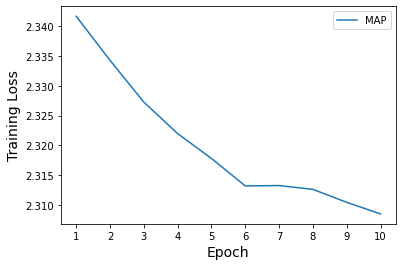

In [20]:
plot_losses("MAP", model.all_losses(), plt.subplot())